# Trip Advisor Hotel Review Predictive Modelling

## Load Libraries

In [114]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import nltk
from nltk import pos_tag, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Embedding, Flatten, Dense, Dropout, LSTM, SimpleRNN,  Bidirectional
from keras.models import Sequential
import pickle

## Initial EDA

In [66]:
hotelreview = pd.read_csv("tripadvisor_hotel_reviews.csv")
hotelreview.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [67]:
hotelreview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [68]:
hotelreview.isna().sum()

Review    0
Rating    0
dtype: int64

In [69]:
hotelreview.duplicated().sum()

0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, '1421'),
 Text(0, 0, '1793'),
 Text(0, 0, '2184'),
 Text(0, 0, '6039'),
 Text(0, 0, '9054')]

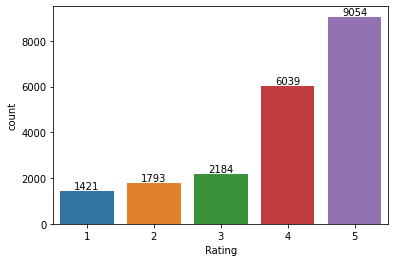

In [70]:
count_rating = sns.countplot(hotelreview["Rating"])
count_rating.bar_label(count_rating.containers[0])

In [71]:
hotelreview.describe()

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [72]:
hotelreview["Review_Length"] = hotelreview["Review"].map(lambda x : len(x))
hotelreview.head()

,Review,Rating,Review_Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


In [73]:
maxLen = hotelreview.groupby("Rating")["Review_Length"].max().reset_index().sort_values(by = "Review_Length", ascending=False, ignore_index=True)
maxLen

,Rating,Review_Length
0,3,13501
1,5,12738
2,4,10062
3,2,7802
4,1,6511


In [74]:
minLen = hotelreview.groupby("Rating")["Review_Length"].min().reset_index().sort_values(by = "Review_Length", ascending=True, ignore_index=True)
minLen

,Rating,Review_Length
0,5,44
1,3,47
2,4,61
3,2,74
4,1,77


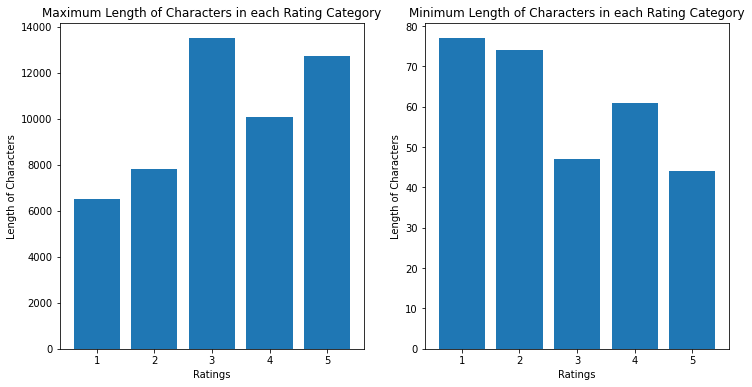

In [75]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.bar(maxLen["Rating"], maxLen["Review_Length"])
plt.xlabel("Ratings")
plt.ylabel("Length of Characters")
plt.title("Maximum Length of Characters in each Rating Category")

plt.subplot(122)
plt.bar(minLen["Rating"], minLen["Review_Length"])
plt.xlabel("Ratings")
plt.ylabel("Length of Characters")
plt.title("Minimum Length of Characters in each Rating Category")

plt.show()

In [77]:
def categorize_rating(rating):
    if rating > 3:
        return 'Satisfied'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Not Satisfied'

In [78]:
hotelreview['Rating'] = hotelreview['Rating'].apply(categorize_rating)

## Text Preprocessing

In [79]:
sw = nltk.corpus.stopwords.words('english')

In [80]:
def rm_stopword(x):
    result = [i for i in x if i not in sw]
    return result

In [81]:
# Lemmatization (so that word doesn't lose meaning after stemming)
word_lemmatize = WordNetLemmatizer()

In [82]:
def create_tag(tags):
    convert_tag = {'NN':'n', 'JJ':'a', 'VB': 'v', 'RB': 'r'}
    try:
        return convert_tag[tags[:2]]
    except:
        return 'n'

def lemmatize_sentence(text):
    return [word_lemmatize.lemmatize(word.lower(), pos = create_tag(tag))
    for word, tag in pos_tag(word_tokenize(text))]

In [83]:
def clean_text(rev):
    rev = re.sub('[^a-zA-Z0-9]', ' ', rev)
    #rev = re.sub("\d+", "", rev)
    rev = re.compile(r"\s+").sub(' ', rev)
    rev = rev.lower().split()
    rev = rm_stopword(rev)
    # join words back together to lemmatize based on tags
    full = ' '.join(rev)
    full = lemmatize_sentence(full)
    # rejoin the words have it being separated
    full = ' '.join(full)
    return full


In [84]:
hotelreview["Clean_Text"] = hotelreview["Review"].apply(clean_text)
hotelreview.head()

,Review,Rating,Review_Length,Clean_Text
0,nice hotel expensive parking got good deal sta...,Satisfied,593,nice hotel expensive parking get good deal sta...
1,ok nothing special charge diamond member hilto...,Not Satisfied,1689,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,Neutral,1427,nice room 4 experience hotel monaco seattle go...
3,"unique, great stay, wonderful time hotel monac...",Satisfied,600,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",Satisfied,1281,great stay great stay go seahawk game awesome ...


In [85]:
hotelreview["Review_Length_2"] = hotelreview["Clean_Text"].map(lambda x : len(x))
hotelreview.head()

,Review,Rating,Review_Length,Clean_Text,Review_Length_2
0,nice hotel expensive parking got good deal sta...,Satisfied,593,nice hotel expensive parking get good deal sta...,523
1,ok nothing special charge diamond member hilto...,Not Satisfied,1689,ok nothing special charge diamond member hilto...,1534
2,nice rooms not 4* experience hotel monaco seat...,Neutral,1427,nice room 4 experience hotel monaco seattle go...,1307
3,"unique, great stay, wonderful time hotel monac...",Satisfied,600,unique great stay wonderful time hotel monaco ...,543
4,"great stay great stay, went seahawk game aweso...",Satisfied,1281,great stay great stay go seahawk game awesome ...,1104


In [86]:
hotelreview.describe()

,Review_Length,Review_Length_2
count,20491.000000,20491.000000
mean,724.896833,653.408814
std,689.101024,614.026037
min,44.000000,32.000000
25%,339.000000,309.000000
50%,537.000000,485.000000
75%,859.000000,778.000000
max,13501.000000,12119.000000


In [87]:
# drop columns we don't need
hotelreview.drop(['Review','Review_Length', 'Review_Length_2'], axis = 1, inplace=True)
hotelreview = hotelreview.rename(columns={"Clean_Text": "Review"})

In [88]:
X = hotelreview["Review"]
y = hotelreview["Rating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [89]:
print('X training data: ', X_train.shape, '; ', 'y training data: ', y_train.shape, '; ', 'X testing data: ', X_test.shape, '; ', 'y testing data: ', y_test.shape)

X training data:  (16392,) ;  y training data:  (16392,) ;  X testing data:  (4099,) ;  y testing data:  (4099,)


## Tokenize and Vectorize

In [92]:
tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
vocab_len = len(tokenizer.word_index)
print('Total Number of Unique Words: {}'.format(vocab_len))
train_sequence = tokenizer.texts_to_sequences(X_train)
train_paddedseq = pad_sequences(train_sequence)

test_sequence = tokenizer.texts_to_sequences(X_test)
test_paddedseq = pad_sequences(test_sequence)

# to_categorical assumes categories start from 0, thus I subtracted 1 from all categories to make it go from 0 to 4
#y_train = to_categorical(y_train - 1, num_classes = 3)
#y_test = to_categorical(y_test - 1, num_classes= 3)

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

Total Number of Unique Words: 40935


In [115]:
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))
pickle.dump(lb, open('label.pkl', 'wb'))

In [107]:
# Modelling
model = Sequential()
model.add(Embedding(vocab_len+1, 16))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5)) # Inputs not set to 0 are scaled up by 1/(1-rate)
model.add(Dense(16, activation = 'relu', kernel_regularizer= l2(0.0015)))#, bias_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, None, 16)          654976    
                                                                 
 bidirectional_14 (Bidirecti  (None, 64)               12544     
 onal)                                                           
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 16)                1040      
                                                                 
 dropout_28 (Dropout)        (None, 16)                0         
                                                                 
 dense_28 (Dense)            (None, 3)                 51        
                                                     

In [108]:
model.compile(optimizer=tf.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_paddedseq, y_train, epochs=15, validation_data=(test_paddedseq, y_test))

Epoch 1/15
513/513 [==============================] - 280s 537ms/step - loss: 0.6758 - accuracy: 0.7654 - val_loss: 0.4894 - val_accuracy: 0.8224
Epoch 2/15
513/513 [==============================] - 272s 530ms/step - loss: 0.4315 - accuracy: 0.8466 - val_loss: 0.4887 - val_accuracy: 0.8243
Epoch 3/15
513/513 [==============================] - 272s 529ms/step - loss: 0.3477 - accuracy: 0.8688 - val_loss: 0.4753 - val_accuracy: 0.8217
Epoch 4/15
513/513 [==============================] - 272s 531ms/step - loss: 0.2937 - accuracy: 0.8882 - val_loss: 0.5642 - val_accuracy: 0.8348
Epoch 5/15
513/513 [==============================] - 273s 532ms/step - loss: 0.2713 - accuracy: 0.9020 - val_loss: 0.5701 - val_accuracy: 0.8131
Epoch 6/15
513/513 [==============================] - 273s 532ms/step - loss: 0.2348 - accuracy: 0.9127 - val_loss: 0.6203 - val_accuracy: 0.8092
Epoch 7/15
513/513 [==============================] - 272s 531ms/step - loss: 0.2072 - accuracy: 0.9275 - val_loss: 0.9002 -

In [110]:
pred = model.predict(test_paddedseq)
true_labels = np.argmax(y_test, axis = -1)
pred_labels = np.argmax(pred, axis = -1)

129/129 [==============================] - 20s 151ms/step


In [112]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.32      0.27      0.29       471
           1       0.62      0.80      0.70       640
           2       0.91      0.88      0.89      2988

    accuracy                           0.79      4099
   macro avg       0.62      0.65      0.63      4099
weighted avg       0.80      0.79      0.79      4099



In [113]:
model.evaluate(test_paddedseq, y_test)

129/129 [==============================] - 19s 149ms/step - loss: 1.7665 - accuracy: 0.7946


[1.7664785385131836, 0.7945840358734131]

In [116]:
model.save('nn_model.h5')

In [117]:
def nn_predict(rating):
    clean_sentence = clean_text(rating)
    seq = tokenizer.texts_to_sequences([clean_sentence])
    pad = pad_sequences(seq)
    pred = model.predict(pad)
    result = lb.inverse_transform(pred)[0] # gets label name
    return result

In [118]:
rating_1 = 'Great and comfortable place to stay'
print(nn_predict(rating_1))

1/1 [==============================] - 1s 1s/step
Satisfied


In [129]:
rating_2 = 'The food was ok, and the scenery was nice'
print(nn_predict(rating_2))

1/1 [==============================] - 0s 34ms/step
Neutral


In [124]:
rating_3 = 'It was in a bad location and the service was horrible'
print(nn_predict(rating_3))

1/1 [==============================] - 0s 20ms/step
Not Satisfied
